In [28]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'user_id': [12315133,42645131], 'sum_usd': [120, 280], 'date': ['2025-01-01', '2025-01-05']})
df

,user_id,sum_usd,date
0,12315133,120,2025-01-01
1,42645131,280,2025-01-05


In [197]:
np.random.rand()

0.06489224710898156

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def generate_synthetic_data(start_date: str, end_date: str, n_users: int) -> pd.DataFrame:
    """Генерация синтетических данных с постепенным добавлением пользователей."""
    np.random.seed(42)
    
    dates = pd.date_range(start_date, end_date)
    data = []
    
    for user_id in range(n_users):
        # Случайная дата регистрации пользователя
        registration_date = np.random.choice(dates)
    
        # Генерируем данные только для дат после регистрации
        for date in dates[dates >= registration_date]:
            num_withdrawals = np.random.choice([0, 1, 2], p=[0.7, 0.2, 0.1])
            for _ in range(num_withdrawals):
                amount = round(np.random.uniform(10, 1000), 2)
                feature_1 = np.random.randint(100, 200)
                feature_2 = np.random.choice([0, 1, 2], p=[0.2, 0.7, 0.1])
                # Возраст увеличивается с каждой датой
                user_lifetime = (date - registration_date).days

                # Влияние признаков на target
                base_probability = 0.1
                probability_boost = (amount / 1000) * 0.3 + \
                                    (feature_1 / 200) * 0.02 + \
                                    (feature_2 / 2) * 0.01
                if user_lifetime < 100:
                    probability_boost += 0.2
                elif user_lifetime < 200:
                    probability_boost += 0.01
                else:
                    probability_boost += 0.005
                probability = base_probability + probability_boost
    
                target = np.random.choice([0, 1], p=[1 - probability, probability])
    
                data.append({
                    'user_id': user_id,
                    'date': date,
                    'amount': amount,
                    'feature_1': feature_1,
                    'feature_2': feature_2,
                    'user_lifetime': user_lifetime,
                    'target': target
                })
    return pd.DataFrame(data)

start_date = '2023-01-01'
end_date = '2024-12-31'
n_users = 100
df = generate_synthetic_data(start_date, end_date, n_users)

print('Shape:', df.shape)
val_counts = df['target'].value_counts()
zero_class_weight = round(100 - val_counts[1]*100/(val_counts[0]+val_counts[1]),2)
first_class_weight = round(val_counts[1]*100/(val_counts[0]+val_counts[1]),2)
print(f'\nClass weights\n1: {first_class_weight}\n0: {zero_class_weight}')
df.head(5)

Shape: (14500, 7)

Class weights
1: 32.98
0: 67.02


,user_id,date,amount,feature_1,feature_2,user_lifetime,target
0,0,2023-04-13,191.60,171,1,0,0
1,0,2023-04-16,605.10,123,1,3,0
2,0,2023-04-17,939.17,101,0,4,0
3,0,2023-04-27,207.68,154,2,14,0
4,0,2023-04-28,683.50,172,0,15,1


In [2]:
def categorize_user_lifetime(user_lifetime: int) -> str:
    """Категоризация user_lifetime"""
    if user_lifetime < 100:
        return 'young'
    elif user_lifetime < 200:
        return 'average'
    else:
        return 'elderly'

def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """Работа с признаками для замедления устаревания"""
    # user_lifetime
    df['user_lifetime_category'] = df['user_lifetime'].apply(categorize_user_lifetime)
    df.drop(['user_lifetime'], axis=1, inplace=True)
    return df

df = feature_engineering(df)

print(df['user_lifetime_category'].value_counts())
df.head()

user_lifetime_category
elderly    7551
young      3867
average    3082
Name: count, dtype: int64


,user_id,date,amount,feature_1,feature_2,target,user_lifetime_category
0,0,2023-04-13,191.60,171,1,0,young
1,0,2023-04-16,605.10,123,1,0,young
2,0,2023-04-17,939.17,101,0,0,young
3,0,2023-04-27,207.68,154,2,0,young
4,0,2023-04-28,683.50,172,0,1,young


In [341]:
# df['month'] = df['date'].dt.month

# for i in df['month'].unique():
#     tmp =  df[df['month'] == i]
#     print('===')
#     print(i)
#     print(tmp['user_lifetime_category'].value_counts())

In [5]:
def train_and_evaluate(data: pd.DataFrame, target_column: str, cat_features: list, show_eval_res=False) -> tuple:
    """Обучает модель и оценивает ее качество."""
    data = data.sort_values(by=['date'])
    
    X = data.drop([target_column, 'user_id'], axis=1)
    y = data[target_column]

    X_train_val =  X[:-500]
    y_train_val = y[:-500]

    val_counts = y_train_val.value_counts()
    zero_class_weight = round(1-val_counts[1]/(val_counts[0]+val_counts[1]),2)
    first_class_weight = round(val_counts[1]/(val_counts[0]+val_counts[1]),2)
    class_weights = [zero_class_weight, first_class_weight]

    X_test =  X[-500:]
    y_test = y[-500:]
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, 
                                                      random_state=42, stratify=y_train_val)

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    validate_pool = Pool(X_val, y_val, cat_features=cat_features)
    test_pool = Pool(X_test, y_test, cat_features=cat_features)

    model = CatBoostClassifier(
        random_state=42,
        verbose=0,
        class_weights=class_weights,
        eval_metric='AUC',
        early_stopping_rounds=50
    )

    model.fit(train_pool, eval_set=validate_pool)

    y_pred_proba = model.predict_proba(X_train_val)[:, 1]
    auc_val = roc_auc_score(y_train_val, y_pred_proba)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, y_pred_proba)

    if show_eval_res is True:
        print(f'Validate AUC: {round(auc_val,3)}')
        print(f'Test AUC: {round(auc_test,3)}')
    
    return auc_val, auc_test, model

# Определяем категориальные признаки
categorical_features = ['feature_2','user_lifetime_category']
target_column = 'target'
class_weights = [zero_class_weight, first_class_weight]

auc_val, auc_test, model = train_and_evaluate(df, target_column, cat_features=categorical_features, show_eval_res=True)

Validate AUC: 0.665
Test AUC: 0.654


In [10]:
def find_optimal_data_window(df, date_column, target_column, window_sizes=None, cat_features=None):
    """
    Находит оптимальный временной период для обучения модели.
    """
    if window_sizes is None:
        window_sizes = range(1,23)

    results_val = {}
    results_test = {}
    for window in window_sizes:
        cutoff_date = df[date_column].max() - pd.DateOffset(months=window)
        truncated_df = df[df[date_column] >= cutoff_date].copy()

        if len(truncated_df) == 0:
            print(f"Предупреждение: Нет данных для окна {window} месяцев. Пропускаем.")
            results_val[f'{window}'] = -np.inf
            results_test[f'{window}'] = -np.inf
            continue

        try:
            auc_val, auc_test, trained_model = train_and_evaluate(truncated_df, target_column, cat_features=cat_features)
            results_val[f'{window}'] = auc_val
            results_test[f'{window}'] = auc_test
            print(f"Test AUC для окна {window} месяцев: {auc_test}")
        except Exception as e:
            print(f"Ошибка при обучении модели для окна {window} месяцев: {e}")
            results_val[f'{window}'] = -np.inf
            results_test[f'{window}'] = -np.inf

    best_window = max(results_test, key=results_test.get)
    best_auc = results_test[best_window]

    print(f"\nЛучший размер окна: {best_window} месяцев с AUC: {best_auc}")

    return best_window, best_auc, results_test, results_val

# Определяем категориальные признаки
categorical_features = ['feature_2','user_lifetime_category']

# Запускаем поиск оптимального окна
best_window, best_auc,  results_test, results_val = find_optimal_data_window(df, 'date','target', cat_features=categorical_features)

Test AUC для окна 1 месяцев: 0.6228787609395681
Test AUC для окна 2 месяцев: 0.6153968791725621
Test AUC для окна 3 месяцев: 0.6362828187044389
Test AUC для окна 4 месяцев: 0.6563901233583771
Test AUC для окна 5 месяцев: 0.6612536794484285
Test AUC для окна 6 месяцев: 0.654484126984127
Test AUC для окна 7 месяцев: 0.6619900755296041
Test AUC для окна 8 месяцев: 0.6294079298287204
Test AUC для окна 9 месяцев: 0.6581125664276261
Test AUC для окна 10 месяцев: 0.645289862292991
Test AUC для окна 11 месяцев: 0.6542559523809524
Test AUC для окна 12 месяцев: 0.659515201801695
Test AUC для окна 13 месяцев: 0.6770138888888889
Test AUC для окна 14 месяцев: 0.6449404761904762
Test AUC для окна 15 месяцев: 0.6577652005819168
Test AUC для окна 16 месяцев: 0.6567886964666494
Test AUC для окна 17 месяцев: 0.6583199984195657
Test AUC для окна 18 месяцев: 0.659265873015873
Test AUC для окна 19 месяцев: 0.6614484126984127
Test AUC для окна 20 месяцев: 0.649923282713038
Test AUC для окна 21 месяцев: 0.65

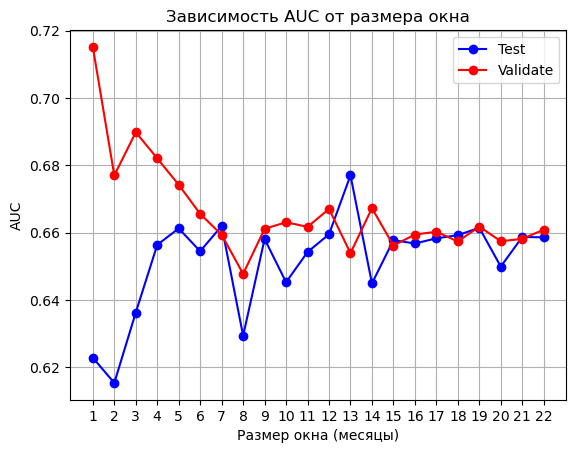

In [16]:
# Визуализация
def create_plot_auc(results: dict, color:str, label:str):
    """Создает линейный график зависимости AUC от размера окна"""
    window_sizes = list(results.keys())
    auc_scores = list(results.values())
    plt.plot(window_sizes, auc_scores, marker='o', color=color, label=label)

create_plot_auc(results_test, 'blue','Test')
create_plot_auc(results_val, 'red', 'Validate')
plt.xlabel("Размер окна (месяцы)")
plt.ylabel("AUC")
plt.title("Зависимость AUC от размера окна")
plt.xticks(window_sizes)
plt.grid(True)
plt.legend()
plt.show()

In [18]:
date_column = 'date'

results = {}
cutoff_date_min = start_date
for i in range(10):
    window = 13+i

    cutoff_date_min = pd.to_datetime(cutoff_date_min) + pd.DateOffset(months=1)
    cutoff_date_max = cutoff_date_min + pd.DateOffset(months=13)
    truncated_df = df[(df[date_column] >= cutoff_date_min)&(df[date_column] <= cutoff_date_max)].copy()

    # Определяем категориальные признаки
    categorical_features = ['feature_2','user_lifetime_category']
    target_column = 'target'

    auc_val, auc_test, trained_model = train_and_evaluate(truncated_df, target_column, cat_features=categorical_features)
    results[window] = auc_test
    print(f"Test AUC для окна {window} месяцев: {auc_test}")


Test AUC для окна 13 месяцев: 0.6795343248803043
Test AUC для окна 14 месяцев: 0.6635378856624319
Test AUC для окна 15 месяцев: 0.6545666513880309
Test AUC для окна 16 месяцев: 0.6249213156031158
Test AUC для окна 17 месяцев: 0.5935264240592744
Test AUC для окна 18 месяцев: 0.6682092044134728
Test AUC для окна 19 месяцев: 0.6562116093366094
Test AUC для окна 20 месяцев: 0.6719102829275698
Test AUC для окна 21 месяцев: 0.6548346011584899
Test AUC для окна 22 месяцев: 0.6866762500216492


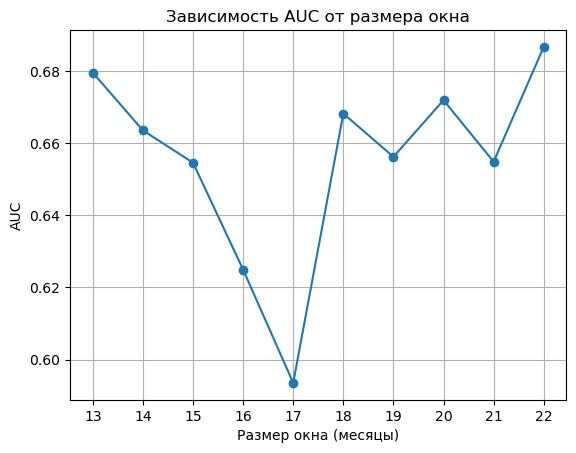

In [19]:
# Визуализация (остается без изменений)
window_sizes = list(results.keys())
auc_scores = list(results.values())

plt.plot(window_sizes, auc_scores, marker='o')
plt.xlabel("Размер окна (месяцы)")
plt.ylabel("AUC")
plt.title("Зависимость AUC от размера окна")
plt.xticks(window_sizes)
plt.grid(True)
plt.show()

In [ ]:
def create_x_y(X: pd.DataFrame, y: pd.Series, window:int,how='best_window'):
    if how=='best_window':
        X_train_val =  X[:-500]
        y_train_val = y[:-500]
        X_test =  X[-500:]
        y_test = y[-500:]
    elif:
        
    else:
        raise ValueError('Недопустимое значение how')
    

def train_and_evaluate(data: pd.DataFrame, target_column: str, cat_features: list, show_eval_res=False) -> tuple:
    """Обучает модель и оценивает ее качество."""
    data = data.sort_values(by=['date'])
    
    X = data.drop([target_column, 'user_id'], axis=1)
    y = data[target_column]

    X_train_val =  X[:-500]
    y_train_val = y[:-500]
    X_test =  X[-500:]
    y_test = y[-500:]

    val_counts = y_train_val.value_counts()
    zero_class_weight = round(1-val_counts[1]/(val_counts[0]+val_counts[1]),2)
    first_class_weight = round(val_counts[1]/(val_counts[0]+val_counts[1]),2)
    class_weights = [zero_class_weight, first_class_weight]

    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, 
                                                      random_state=42, stratify=y_train_val)

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    validate_pool = Pool(X_val, y_val, cat_features=cat_features)
    test_pool = Pool(X_test, y_test, cat_features=cat_features)

    model = CatBoostClassifier(
        random_state=42,
        verbose=0,
        class_weights=class_weights,
        eval_metric='AUC',
        early_stopping_rounds=50
    )

    model.fit(train_pool, eval_set=validate_pool)

    y_pred_proba = model.predict_proba(X_train_val)[:, 1]
    auc_val = roc_auc_score(y_train_val, y_pred_proba)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, y_pred_proba)

    if show_eval_res is True:
        print(f'Validate AUC: {round(auc_val,3)}')
        print(f'Test AUC: {round(auc_test,3)}')
    
    return auc_val, auc_test, model

# Определяем категориальные признаки
categorical_features = ['feature_2','user_lifetime_category']
target_column = 'target'
class_weights = [zero_class_weight, first_class_weight]

auc_val, auc_test, model = train_and_evaluate(df, target_column, cat_features=categorical_features, show_eval_res=True)

In [22]:
X = df.drop([target_column, 'user_id'], axis=1)
y = df[target_column]

In [25]:
how = 'decay_rate'

if how=='best_window':
    X = df.drop([target_column, 'user_id'], axis=1)
    y = df[target_column]
    
    X_train_val =  X[:-500]
    y_train_val = y[:-500]
    X_test =  X[-500:]
    y_test = y[-500:]
elif how=='decay_rate':
    
else:
    raise ValueError('Недопустимое значение how')

pandas.core.series.Series

In [27]:
df['date'].dt.month

0         4
1         4
2         4
3         4
4         4
         ..
14495    12
14496    12
14497    12
14498    12
14499    12
Name: date, Length: 14500, dtype: int32

In [30]:
from dateutil.relativedelta import relativedelta

# Вычисляем количество месяцев, прошедших с начальной даты
start_date = pd.to_datetime('2023-01-01')
df['month_number'] = df['date'].apply(lambda date: relativedelta(date, start_date).months + 12 * relativedelta(date, start_date).years + 1)

In [35]:
df[df['month_number'] <= 13]

,user_id,date,amount,feature_1,feature_2,target,user_lifetime_category,month_number
0,0,2023-04-13,191.60,171,1,0,young,4
1,0,2023-04-16,605.10,123,1,0,young,4
2,0,2023-04-17,939.17,101,0,0,young,4
3,0,2023-04-27,207.68,154,2,0,young,4
4,0,2023-04-28,683.50,172,0,1,young,4
...,...,...,...,...,...,...,...,...
14362,99,2024-01-15,76.61,138,1,0,average,13
14363,99,2024-01-20,701.25,154,0,0,average,13
14364,99,2024-01-27,994.85,157,1,1,average,13
14365,99,2024-01-27,297.62,149,1,1,average,13


In [ ]:
date_column = 'date'

results = {}
cutoff_date_min = start_date
for i in range(10):
    window = 13+i

    cutoff_date_min = pd.to_datetime(cutoff_date_min) + pd.DateOffset(months=1)
    cutoff_date_max = cutoff_date_min + pd.DateOffset(months=13)
    truncated_df = df[(df[date_column] >= cutoff_date_min)&(df[date_column] <= cutoff_date_max)].copy()

    # Определяем категориальные признаки
    categorical_features = ['feature_2','user_lifetime_category']
    target_column = 'target'

    auc_val, auc_test, trained_model = train_and_evaluate(truncated_df, target_column, cat_features=categorical_features)
    results[window] = auc_test
    print(f"Test AUC для окна {window} месяцев: {auc_test}")
